In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import openml
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
import matplotlib.pyplot as plt

import pycaret
from pycaret.classification import ClassificationExperiment
from pycaret.datasets import get_data

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

from ydata_profiling import ProfileReport

from earlymed import LearningCurve, FeatureCurve, FeatureLearningPlot

In [2]:
full_data = openml.datasets.get_dataset(40966).get_data()[0]
full_data.shape

(1080, 78)

In [3]:
data, _ = train_test_split(full_data, train_size=200, random_state=0)

In [4]:
profile = ProfileReport(data, title="Pandas Profiling Report", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 507 to 684
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   DYRK1A_N         200 non-null    float64 
 1   ITSN1_N          200 non-null    float64 
 2   BDNF_N           200 non-null    float64 
 3   NR1_N            200 non-null    float64 
 4   NR2A_N           200 non-null    float64 
 5   pAKT_N           200 non-null    float64 
 6   pBRAF_N          200 non-null    float64 
 7   pCAMKII_N        200 non-null    float64 
 8   pCREB_N          200 non-null    float64 
 9   pELK_N           200 non-null    float64 
 10  pERK_N           200 non-null    float64 
 11  pJNK_N           200 non-null    float64 
 12  PKCA_N           200 non-null    float64 
 13  pMEK_N           200 non-null    float64 
 14  pNR1_N           200 non-null    float64 
 15  pNR2A_N          200 non-null    float64 
 16  pNR2B_N          200 non-null    float64 
 17  

In [6]:
n_classes = data['class'].unique().size

---
### CatBoostEncoder

In [7]:
exp = ClassificationExperiment()
exp.setup(
    data,
    target='class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [8]:
best = exp.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

In [9]:
best = exp.create_model('lr')

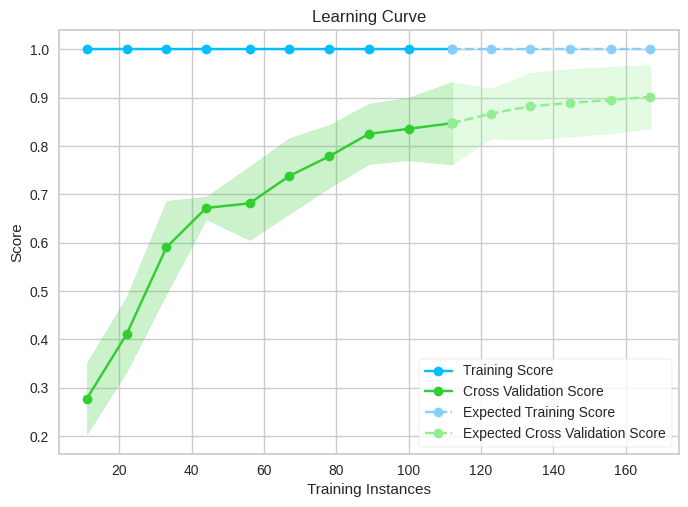

In [10]:
lc = LearningCurve(best, predict_extend_points=5)
lc.fit(exp.X_train_transformed, exp.y_train_transformed)

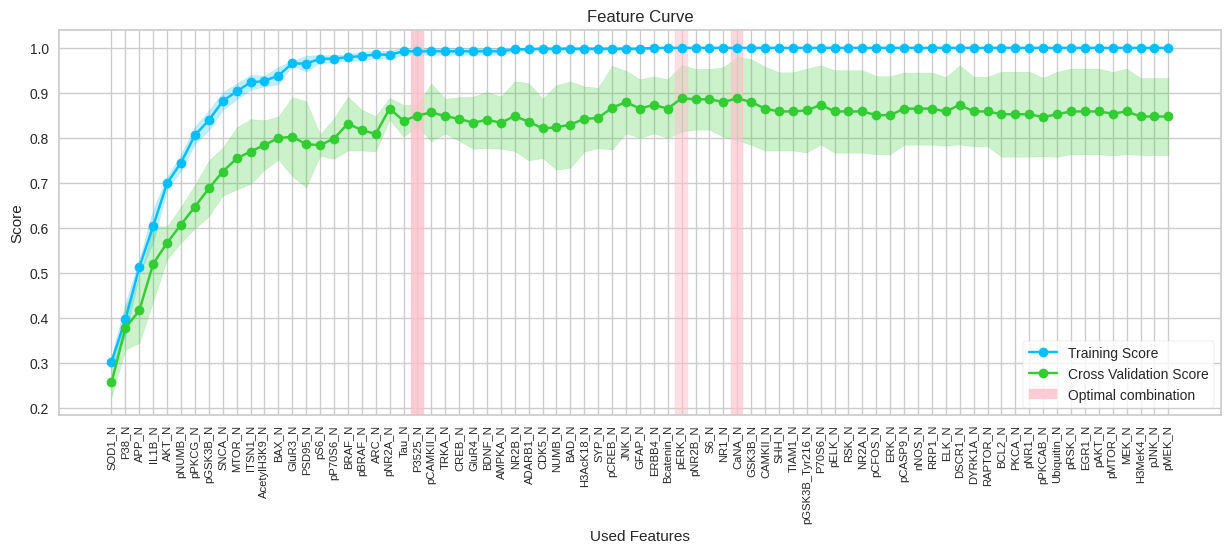

In [11]:
_, ax = plt.subplots(figsize=(15, 5))
fc = FeatureCurve(best, ax=ax)
fc.fit(exp.X_train_transformed, exp.y_train_transformed)

In [12]:
fc.features_order[:23]

Index(['SOD1_N', 'P38_N', 'APP_N', 'IL1B_N', 'AKT_N', 'pNUMB_N', 'pPKCG_N',
       'pGSK3B_N', 'SNCA_N', 'MTOR_N', 'ITSN1_N', 'AcetylH3K9_N', 'BAX_N',
       'GluR3_N', 'PSD95_N', 'pS6_N', 'pP70S6_N', 'BRAF_N', 'pBRAF_N', 'ARC_N',
       'pNR2A_N', 'Tau_N', 'P3525_N'],
      dtype='object')

CPU times: user 25 s, sys: 43.1 ms, total: 25.1 s
Wall time: 25.1 s


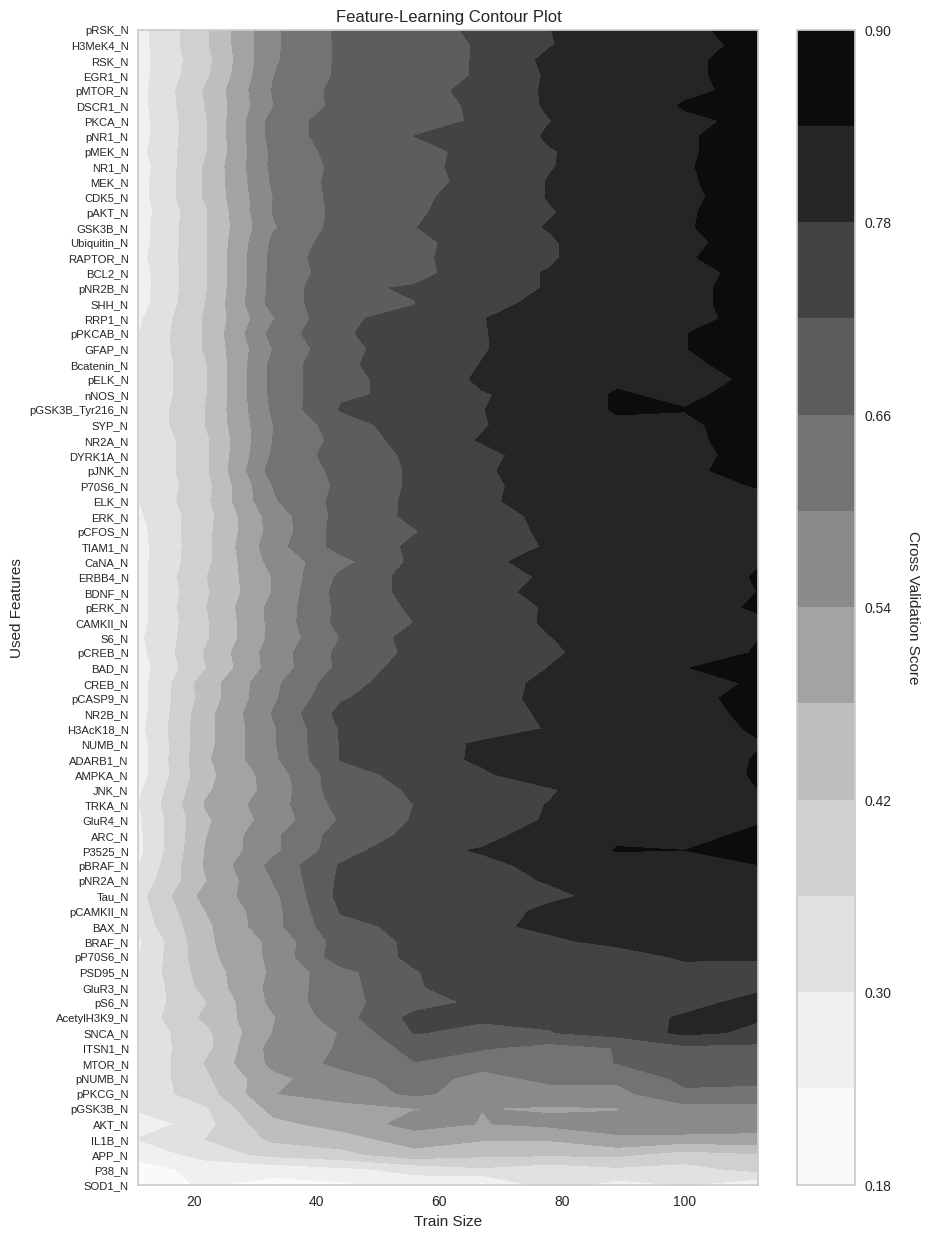

In [13]:
%%time
flc = FeatureLearningPlot(best, figsize=(10, 15))
flc.fit(exp.X_train_transformed, exp.y_train_transformed)

---
### TabEBM with CatBoostEncoder

In [14]:
from tabebm.TabEBM import TabEBM

In [15]:
tabebm = TabEBM(plotting=False)
augmented_data = tabebm.generate(exp.X_train_transformed.values, exp.y_train_transformed.values, num_samples=500//n_classes)

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.11/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_42.cpkt
It has about 100MB, so this might take a moment.


In [16]:
X_syn = np.concatenate(list(augmented_data.values()))
y_syn = np.concatenate([np.full(len(augmented_data[f"class_{i}"]), i) for i in range(len(augmented_data.keys()))])
X_train_augmented = np.concatenate([exp.X_train_transformed, X_syn])
y_train_augmented = np.concatenate([exp.y_train_transformed, y_syn])

In [17]:
best.fit(exp.X_train_transformed, exp.y_train_transformed)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.7470734126984127

In [18]:
best.fit(X_train_augmented, y_train_augmented)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.8206845238095237

---
### Full data experiement

In [19]:
exp_full = ClassificationExperiment()
exp_full.setup(
    full_data,
    target='class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [20]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

In [21]:
exp_full = ClassificationExperiment()
exp_full.setup(
    full_data[[*fc.features_order[:23], 'class']],
    target='class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [22]:
fc.features_order[:23]

Index(['SOD1_N', 'P38_N', 'APP_N', 'IL1B_N', 'AKT_N', 'pNUMB_N', 'pPKCG_N',
       'pGSK3B_N', 'SNCA_N', 'MTOR_N', 'ITSN1_N', 'AcetylH3K9_N', 'BAX_N',
       'GluR3_N', 'PSD95_N', 'pS6_N', 'pP70S6_N', 'BRAF_N', 'pBRAF_N', 'ARC_N',
       'pNR2A_N', 'Tau_N', 'P3525_N'],
      dtype='object')

In [23]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)